In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [3]:
df = pd.read_hdf('freesolv_with_samples.h5')

In [4]:
from openforcefield.topology import Molecule

In [4]:
inds = list(df.index)


allowed_elements = {1, 6, 7, 8, 17}

cho_freesolv = []
for key in inds:
    offmol = df['offmol'][key]
    if set([a.atomic_number for a in offmol.atoms]).issubset(allowed_elements):
        cho_freesolv.append(key)
print(len(cho_freesolv))

529


In [5]:
np.random.seed(0)
inds = list(cho_freesolv)
np.random.shuffle(inds)
train_inds = inds[::2]
valid_inds = inds[1::2]
len(train_inds), len(valid_inds)

(265, 264)

In [6]:
from openmmtools.constants import kB
from simtk import unit
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

temperature = 300 * unit.kelvin
kT = kB * temperature

# conversion from espaloma energy unit to kT
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

Using backend: pytorch


1052.5821686494048

In [7]:
df['offmol']['mobley_1017962'].partial_charges

Quantity(value=array([-0.09266   , -0.07967   , -0.07829   , -0.07824   , -0.12671   ,
        0.63147002, -0.53658998, -0.44984001,  0.12808   ,  0.03392   ,
        0.03392   ,  0.03392   ,  0.04138   ,  0.04138   ,  0.03957   ,
        0.03957   ,  0.05656   ,  0.05656   ,  0.07839   ,  0.07839   ,
        0.04963   ,  0.04963   ,  0.04963   ]), unit=elementary charge)

In [8]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
df['distance_matrices'] = None

for key in df.index:
    xyz = (df['quick_xyz'][key] * unit.nanometer).value_in_unit(DISTANCE_UNIT)
    distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
    distance_matrices = torch.stack(distance_matrices)
    df['distance_matrices'][key] = distance_matrices

In [9]:
df.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system', 'xyz', 'quick_xyz', 'distance_matrices'],
      dtype='object')

In [10]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [11]:
def compute_obc2_energies(
    distance_matrices,
    radii, scales, charges,
    alpha=0.8, beta=0.0, gamma=2.909125
):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges, 
            alpha, beta, gamma,
        )
    return E_s

In [12]:
offmol = df['offmol'][key]

In [13]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

# radii, scales
atom_dim = 2

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, atom_dim), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    graph_model = ValenceModel(node_representation, readouts)
    return graph_model


def predict_obc2_params(offmol, graph_model):
    """output of graph net's atom representation will initially be near zero, just offset by a constant"""
    params = graph_model.forward(offmol)
    radii = params.atoms[:,0] + 2.5
    scales = params.atoms[:,1] + 1
    return radii, scales

In [14]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [15]:
def predict_on_key(key: str, graph_model, batch_size: int = 25, verbose: bool = False) -> float:
    offmol = df['offmol'][key]
    
    radii, scales = predict_obc2_params(offmol, graph_model)
    
    distance_matrices = df['distance_matrices'][key]
    inds = np.random.randint(0, len(distance_matrices), size=batch_size)
    
    charges = torch.tensor(offmol.partial_charges / unit.elementary_charge)
    
    obc2_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    if verbose:
        print(obc2_energies)
    w = obc2_energies * to_kT
    pred_delta_f = one_sided_exp(w)
    
    return pred_delta_f

In [16]:
train_inds

['mobley_8052240',
 'mobley_7455579',
 'mobley_6248915',
 'mobley_8705848',
 'mobley_1278715',
 'mobley_9478823',
 'mobley_7988076',
 'mobley_4219614',
 'mobley_4715906',
 'mobley_8427539',
 'mobley_2183616',
 'mobley_7378987',
 'mobley_6739648',
 'mobley_2850833',
 'mobley_4584540',
 'mobley_5571660',
 'mobley_8260524',
 'mobley_6060301',
 'mobley_3690931',
 'mobley_1827204',
 'mobley_2689721',
 'mobley_3546460',
 'mobley_3378420',
 'mobley_299266',
 'mobley_8882696',
 'mobley_4479135',
 'mobley_1424265',
 'mobley_3144334',
 'mobley_4780078',
 'mobley_5063386',
 'mobley_902954',
 'mobley_6619554',
 'mobley_3762186',
 'mobley_3682850',
 'mobley_6896128',
 'mobley_2493732',
 'mobley_8764620',
 'mobley_2958326',
 'mobley_9913368',
 'mobley_1019269',
 'mobley_1235151',
 'mobley_2402487',
 'mobley_397645',
 'mobley_7758918',
 'mobley_2923700',
 'mobley_646007',
 'mobley_8785107',
 'mobley_4609460',
 'mobley_3151666',
 'mobley_8311303',
 'mobley_4434915',
 'mobley_468867',
 'mobley_7417968'

In [17]:
from tqdm import tqdm

In [18]:
import matplotlib.pyplot as plt

In [19]:
from openforcefield.topology import Molecule

In [20]:
torch.manual_seed(12345)
np.random.seed(12345)

In [21]:
graph_model = initialize()
learning_rate = 1e-3
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [22]:
keys = train_inds
len(keys)

265

In [23]:
def get_all_preds(keys):
    """TODO: have this (and predict_on_key()) accept an argument that prevents subsampling the configurations"""
    predict_dict = dict()
    for key in keys:
        predict_dict[key] = float(predict_on_key(key, graph_model, 50).detach() * kT / unit.kilocalorie_per_mole)
    return predict_dict

In [24]:
def report_train_and_validation_rmse(predict_dict):
    train_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in train_inds])
    validation_residuals = np.array([predict_dict[key] - df['experimental value (kcal/mol)'][key] for key in valid_inds])
    
    return np.sqrt(np.mean(train_residuals**2)), np.sqrt(np.mean(validation_residuals**2))

In [25]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 15

for t in trange:
    
    # optionally subsample the training set...
    keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        #predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(batch_rmse_in_kcalmol=rmse_in_kcalmol)
    
    n_batches_per_epoch = int(len(train_inds) / n_mols_per_batch)
    
    if t % n_batches_per_epoch == 0:
        epoch = int(t / n_batches_per_epoch)
        p = get_all_preds(cho_freesolv)
        predictions.append(p)
        train_rmse, valid_rmse = report_train_and_validation_rmse(p)
        print(f'training rmse: {train_rmse:.3f}')
        print(f'validation rmse: {valid_rmse:.3f}')
        
        torch.save(graph_model, f'cho_freesolv_epoch={epoch}.pt')

  0%|          | 1/1000 [00:35<9:45:36, 35.17s/it, batch_rmse_in_kcalmol=3.61]

training rmse: 4.154
validation rmse: 3.714


  3%|▎         | 27/1000 [01:19<2:48:43, 10.40s/it, batch_rmse_in_kcalmol=2.61]

training rmse: 2.862
validation rmse: 2.523


  5%|▌         | 53/1000 [02:12<3:13:17, 12.25s/it, batch_rmse_in_kcalmol=3.26]

training rmse: 2.455
validation rmse: 2.151


  8%|▊         | 79/1000 [03:04<3:07:09, 12.19s/it, batch_rmse_in_kcalmol=1.51]

training rmse: 1.896
validation rmse: 2.005


 10%|█         | 105/1000 [03:57<2:57:45, 11.92s/it, batch_rmse_in_kcalmol=2.2]

training rmse: 1.834
validation rmse: 1.978


 13%|█▎        | 131/1000 [04:53<3:09:52, 13.11s/it, batch_rmse_in_kcalmol=1.62]

training rmse: 1.652
validation rmse: 2.145


 16%|█▌        | 157/1000 [05:44<2:46:59, 11.89s/it, batch_rmse_in_kcalmol=4.56] 

training rmse: 1.562
validation rmse: 1.818


 18%|█▊        | 183/1000 [06:36<2:43:23, 12.00s/it, batch_rmse_in_kcalmol=1.21]

training rmse: 1.353
validation rmse: 1.913


 21%|██        | 209/1000 [07:37<3:13:12, 14.66s/it, batch_rmse_in_kcalmol=0.788]

training rmse: 1.296
validation rmse: 2.020


 24%|██▎       | 235/1000 [08:35<2:43:56, 12.86s/it, batch_rmse_in_kcalmol=1.45] 

training rmse: 1.364
validation rmse: 1.631


 26%|██▌       | 261/1000 [09:33<2:47:02, 13.56s/it, batch_rmse_in_kcalmol=2.58] 

training rmse: 1.281
validation rmse: 1.599


 29%|██▊       | 287/1000 [10:27<2:29:21, 12.57s/it, batch_rmse_in_kcalmol=0.864]

training rmse: 1.232
validation rmse: 1.578


 31%|███▏      | 313/1000 [11:25<2:24:20, 12.61s/it, batch_rmse_in_kcalmol=1.48] 

training rmse: 1.234
validation rmse: 1.686


 34%|███▍      | 339/1000 [12:17<2:15:37, 12.31s/it, batch_rmse_in_kcalmol=1.1]  

training rmse: 1.322
validation rmse: 1.613


 36%|███▋      | 365/1000 [13:12<2:17:24, 12.98s/it, batch_rmse_in_kcalmol=1.53] 

training rmse: 1.492
validation rmse: 1.765


 39%|███▉      | 391/1000 [14:10<2:15:06, 13.31s/it, batch_rmse_in_kcalmol=1.22]

training rmse: 1.148
validation rmse: 1.678


 42%|████▏     | 417/1000 [15:07<2:08:21, 13.21s/it, batch_rmse_in_kcalmol=1.58]

training rmse: 1.152
validation rmse: 1.839


 44%|████▍     | 443/1000 [16:06<2:06:55, 13.67s/it, batch_rmse_in_kcalmol=3.15]

training rmse: 1.183
validation rmse: 2.216


 47%|████▋     | 469/1000 [17:04<1:55:44, 13.08s/it, batch_rmse_in_kcalmol=1.7]  

training rmse: 1.120
validation rmse: 1.781


 50%|████▉     | 495/1000 [17:57<1:44:22, 12.40s/it, batch_rmse_in_kcalmol=1.84] 

training rmse: 1.107
validation rmse: 1.744


 52%|█████▏    | 521/1000 [18:48<1:33:52, 11.76s/it, batch_rmse_in_kcalmol=2.8] 

training rmse: 1.825
validation rmse: 2.049


 55%|█████▍    | 547/1000 [19:40<1:32:48, 12.29s/it, batch_rmse_in_kcalmol=3.15]

training rmse: 1.276
validation rmse: 1.539


 57%|█████▋    | 573/1000 [20:34<1:28:18, 12.41s/it, batch_rmse_in_kcalmol=1.83]

training rmse: 1.186
validation rmse: 1.424


 60%|█████▉    | 599/1000 [21:28<1:23:43, 12.53s/it, batch_rmse_in_kcalmol=1.77] 

training rmse: 1.125
validation rmse: 1.373


 62%|██████▎   | 625/1000 [22:25<1:21:56, 13.11s/it, batch_rmse_in_kcalmol=1.15]

training rmse: 1.134
validation rmse: 1.391


 65%|██████▌   | 651/1000 [23:28<1:20:36, 13.86s/it, batch_rmse_in_kcalmol=1.04] 

training rmse: 1.064
validation rmse: 1.320


 68%|██████▊   | 677/1000 [24:31<1:19:44, 14.81s/it, batch_rmse_in_kcalmol=0.71]

training rmse: 1.035
validation rmse: 1.270


 70%|███████   | 703/1000 [25:30<1:03:32, 12.84s/it, batch_rmse_in_kcalmol=1.89]

training rmse: 1.016
validation rmse: 1.237


 73%|███████▎  | 729/1000 [26:24<54:21, 12.04s/it, batch_rmse_in_kcalmol=0.761] 

training rmse: 1.027
validation rmse: 1.246


 76%|███████▌  | 755/1000 [27:14<45:58, 11.26s/it, batch_rmse_in_kcalmol=0.414]

training rmse: 1.005
validation rmse: 1.232


 78%|███████▊  | 781/1000 [28:03<41:36, 11.40s/it, batch_rmse_in_kcalmol=1]    

training rmse: 0.959
validation rmse: 1.168


 81%|████████  | 807/1000 [28:52<35:48, 11.13s/it, batch_rmse_in_kcalmol=0.886]

training rmse: 0.982
validation rmse: 1.270


 83%|████████▎ | 833/1000 [29:44<33:45, 12.13s/it, batch_rmse_in_kcalmol=0.848]

training rmse: 0.988
validation rmse: 1.324


 86%|████████▌ | 859/1000 [30:36<28:04, 11.95s/it, batch_rmse_in_kcalmol=1.4]  

training rmse: 0.961
validation rmse: 1.333


 88%|████████▊ | 885/1000 [31:20<19:14, 10.04s/it, batch_rmse_in_kcalmol=0.489]

training rmse: 0.914
validation rmse: 1.242


 91%|█████████ | 911/1000 [32:10<17:26, 11.76s/it, batch_rmse_in_kcalmol=1.58] 

training rmse: 0.918
validation rmse: 1.297


 94%|█████████▎| 937/1000 [33:01<11:57, 11.39s/it, batch_rmse_in_kcalmol=1.55] 

training rmse: 0.886
validation rmse: 1.254


 96%|█████████▋| 963/1000 [33:51<07:06, 11.53s/it, batch_rmse_in_kcalmol=0.531]

training rmse: 0.879
validation rmse: 1.235


 99%|█████████▉| 989/1000 [34:47<02:24, 13.10s/it, batch_rmse_in_kcalmol=0.578]

training rmse: 0.854
validation rmse: 1.269


100%|██████████| 1000/1000 [34:54<00:00,  2.09s/it, batch_rmse_in_kcalmol=1.13]


In [26]:
def count_params(graph_model):
    n_readout = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.readouts.atoms.state_dict().values()])
    n_rep = sum([torch.prod(torch.tensor(v.shape)) for v in graph_model.node_representation.state_dict().values()])
    return n_rep + n_readout

In [27]:
count_params(graph_model)

tensor(115842)

In [28]:
len(predictions)

39

In [29]:
rmses = np.array([report_train_and_validation_rmse(p) for p in predictions])
rmses[:,1].min()

1.1678099603505632

In [59]:
name = '{C,H,O,N,Cl} mini-freesolv' + f'\n(n={len(cho_freesolv)})'

Text(0.5, 1.0, '{C,H,O,N,Cl} mini-freesolv\n(n=529)')

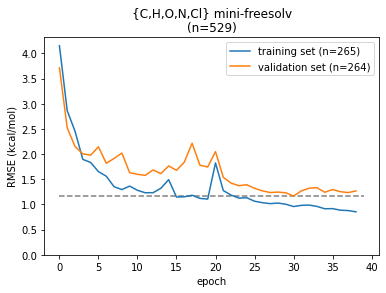

In [60]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0,)
plt.title(name)

Text(0.5, 1.0, '{C,H,O,N,Cl} mini-freesolv\n(n=529)')

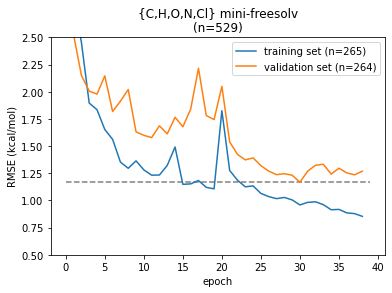

In [61]:
plt.plot(rmses[:,0], label=f'training set (n={len(train_inds)})')
plt.plot(rmses[:,1], label=f'validation set (n={len(valid_inds)})')
plt.legend()
plt.hlines(np.min(rmses[:,1]), 0, len(rmses), linestyles='--', color='grey')
plt.xlabel('epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.ylim(0.5,2.5)
plt.title(name)

In [32]:
np.argmin(rmses[:,1]), len(rmses[:,1])

(30, 39)

In [33]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

Text(0.5, 1.0, 'minibatch loss trajectory')

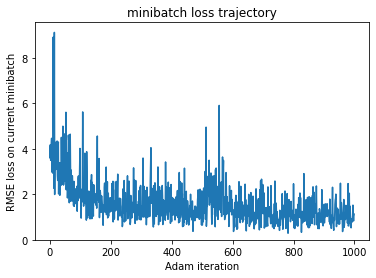

In [34]:
plt.plot(rmse_in_kcalmol)
plt.xlabel('Adam iteration')
plt.ylabel('RMSE loss on current minibatch')
plt.ylim(0,)
plt.title('minibatch loss trajectory')

In [42]:
final_predict_dict = predictions[np.argmin(rmses[:,1])]

In [43]:
float(final_predict_dict[key])

3.085479133361631

In [44]:
splits = {
    'training': train_inds,
    'validation': valid_inds,
}

In [45]:
def bootstrap_rmse(sq_residuals, n_bootstrap=1000):
    N = len(sq_residuals)
    
    rmses = [np.sqrt(np.mean(sq_residuals[np.random.randint(0, N, N)])) for _ in range(n_bootstrap)]
    return np.array(rmses)

In [46]:
def report_rmse_pm_95ci(sq_residuals: np.ndarray, n_bootstrap=1000) -> str:
    rmse = np.sqrt(np.mean(sq_residuals))
    rmses = bootstrap_rmse(sq_residuals)
    return f'{rmse:.2f} ' + r'$\pm$' + f' {1.96 * np.std(rmses):.2f}'

training 0.96 $\pm$ 0.15
validation 1.17 $\pm$ 0.18


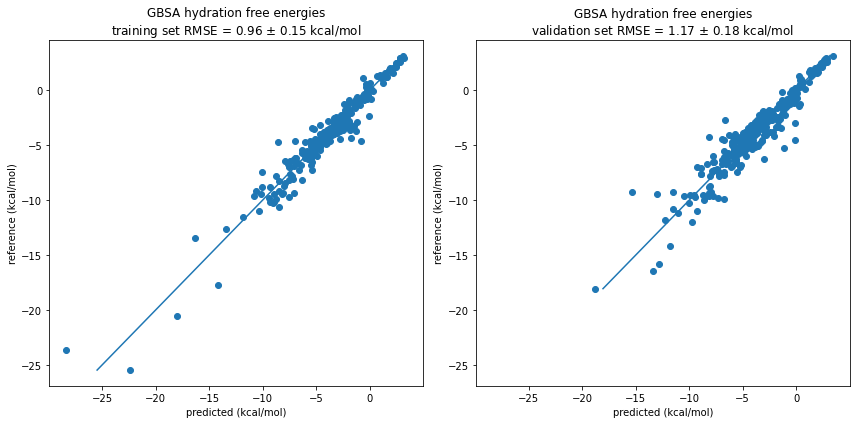

In [49]:
plt.figure(figsize=(12,6))
ax = None

for i, split_name in enumerate(splits):
    split = splits[split_name]
    x = np.array([final_predict_dict[key] for key in split])
    y = np.array([df['experimental value (kcal/mol)'][key] for key in split])
    
    rmse_string = report_rmse_pm_95ci((x - y)**2)
    print(split_name, rmse_string)
    
    
    ax = plt.subplot(1,2,i+1, sharex=ax, sharey=ax)
    plt.scatter(x, y)
    plt.xlabel('predicted (kcal/mol)')
    plt.ylabel('reference (kcal/mol)')
    plt.plot([min(y), max(y)], [min(y), max(y)])

    plt.title(f'GBSA hydration free energies\n{split_name} set RMSE = {rmse_string} kcal/mol')
plt.tight_layout()

In [48]:
# compare with the RMSE that would be obtained by predicting a constant
np.sqrt(np.mean((y - np.mean(y))**2))

3.6046000653049712

#### TODOs:
* Higher-quality vacuum trajectories
* Add bootstrapped rmse bands to train/validation curves, not just to titles of scatterplots
* Do many train/validation splits and report averages / stddevs
* Currently the input is just element identity, one-hot-encoded --> switch to using espaloma's initial atom featurizer?
* Update loss from un-scaled RMSE to something more like a likelihood (incorporating expt error + free-energy-estimator error)
* Do series of mini-freesolvs